In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.5.5
IPython 6.3.0

numpy 1.14.3
sklearn 0.19.1
scipy 1.0.1
matplotlib 2.2.2
tensorflow 1.8.0


**15장 – 오토인코더**

_이 노트북은 15장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import sys

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 선형 오토인코더를 사용한 PCA

3D 데이터셋을 만듭니다:

In [5]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

데이터를 정규화합니다:

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

오토인코더를 만듭니다:

In [7]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # 코딩 유닛
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [8]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

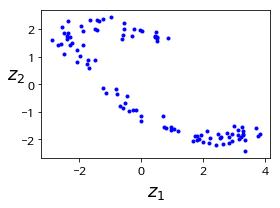

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# 적층 오토인코더

MNIST 데이터셋을 사용합니다:

In [10]:
tf.logging.set_verbosity(tf.logging.ERROR)  # deprecated 경고 메세지를 출력하지 않기 위해 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## 한 번에 모든 층을 훈련하기

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만들어 보겠습니다. ELU 활성화 함수와 He 초기화, L2 정규화를 사용하겠습니다.

In [11]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He 초기화
#아래와 동일합니다:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # 책에는 없음

이제 훈련시켜 보죠! 여기에서는 타깃 값을 주입하지 않습니다(`y_batch`가 사용되지 않습니다). 이는 비지도 학습입니다.

In [12]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # 책에는 없음
            sys.stdout.flush()                                          # 책에는 없음
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # 책에는 없음
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)           # 책에는 없음
        saver.save(sess, "./my_model_all_layers.ckpt")                  # 책에는 없음

0 훈련 MSE: 0.020550018
1 훈련 MSE: 0.01137075
2 훈련 MSE: 0.0102255605
3 훈련 MSE: 0.009902374
4 훈련 MSE: 0.010377134


이 함수는 모델을 로드하고 테스트 세트에서 이를 평가합니다(재구성 오차를 측정합니다). 그런 다음 원본 이미지와 재구성 이미지를 그립니다:

In [13]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


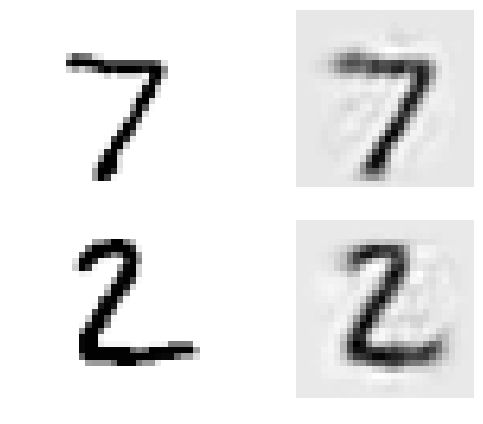

In [14]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## 가중치 묶기

인코더와 디코더의 가중치를 묶는 일은 자주 있습니다(`weights_decoder = tf.transpose(weights_encoder)`). 안타깝지만 `tf.layers.dense()` 함수를 사용해서 이렇게 하기는 불가능합니다(또는 매우 어렵습니다). 수동으로 직접 오토인코더를 만들어야 합니다:

In [15]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [16]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [17]:
saver = tf.train.Saver()

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 훈련 MSE: 0.01506695
1 훈련 MSE: 0.016488748
2 훈련 MSE: 0.017375939
3 훈련 MSE: 0.016878333
4 훈련 MSE: 0.015587721


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


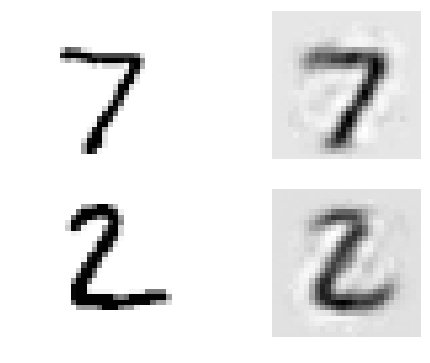

In [19]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## 여러 개의 그래프에서 오토인토더를 따로따로 훈련하기

하나의 오토인코더를 따로따로 훈련하는 방법이 많이 있습니다. 첫 번째 방법은 각 오토인코더를 다른 그래프를 사용하여 훈련하는 것입니다. 그런 다음 이런 오토인코더의 가중치와 편향을 복사해 초깃값으로 지정해서 적층 오토인코더를 만듭니다.

하나의 오토인코더를 훈련하고 변환된 훈련 세트(즉, 은닉층의 출력)와 모델 파라미터를 반환하는 함수를 만들겠습니다.

In [20]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

이제 두 개의 오토인코더를 훈련시켜 보죠. 첫 번째는 훈련 데이터를 사용하고 두 번째는 첫 번째 오토인코더의 은닉층 출력을 사용해 훈련시킵니다:

In [21]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 훈련 MSE: 0.01851794
1 훈련 MSE: 0.01868272
2 훈련 MSE: 0.018467719
3 훈련 MSE: 0.019231746
0 훈련 MSE: 0.004236093
1 훈련 MSE: 0.0048326333
2 훈련 MSE: 0.004668708
3 훈련 MSE: 0.0044038747


마지막으로 방금전 훈련한 오토인코더의 가중치와 편향을 재사용하여 적층 오토인코더를 만듭니다:

In [22]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

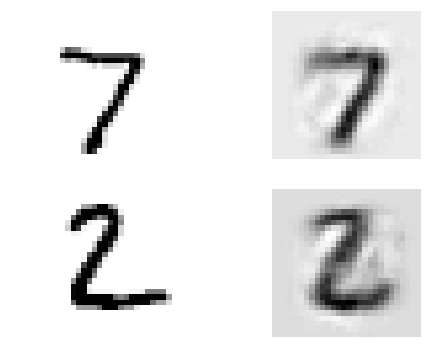

In [23]:
show_reconstructed_digits(X, outputs)

## 하나의 그래프에서 오토인코더를 따로따로 훈련하기

하나의 그래프를 사용하는 방법도 있습니다. 이 방법은 전체 적층 오토인코더를 위한 그래프를 만들지만 각 오토인코더를 독립적으로 훈련하기 위한 연산도 추가합니다. 단계 1은 맨 아래층과 맨 윗층을 훈련하고(즉, 첫 번째 오토인코더), 단계 2는 두 개의 가운데 층을 훈련합니다(즉, 두 번째 오토인코더).

In [24]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결

In [26]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0 훈련 MSE: 0.007406866
1 훈련 MSE: 0.0078288205
2 훈련 MSE: 0.007728097
3 훈련 MSE: 0.0074090064
훈련 단계 #2
09% 훈련 MSE: 0.35758996
1 훈련 MSE: 0.00593613
2 훈련 MSE: 0.0030089526
3 훈련 MSE: 0.0024365915
테스트 MSE: 0.009815396


## 동결 층의 출력을 캐싱하기

In [28]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0 훈련 MSE: 0.0075382586
1 훈련 MSE: 0.007754701
2 훈련 MSE: 0.007343679
3 훈련 MSE: 0.007837775
훈련 단계 #2
0 훈련 MSE: 0.18597357
1 훈련 MSE: 0.0044647465
2 훈련 MSE: 0.002462252
3 훈련 MSE: 0.0020415403
테스트 MSE: 0.009790834


## 재구성 시각화

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


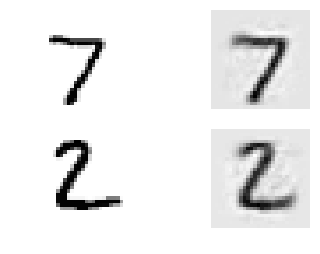

In [29]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## 특성 시각화

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


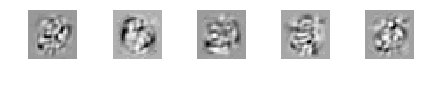

In [30]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # 책에는 없음
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") # 책에는 없음
plt.show()                          # 책에는 없음

# 비지도 사전훈련

MNIST 분류 문제를 위한 작은 신경망을 만들겠습니다:

In [31]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

(사전훈련 없이)평범하게 훈련시킵니다:

In [32]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "훈련 정확도:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("테스트 정확도:", accuracy_val)

0 훈련 정확도: 0.97333336 테스트 정확도: 0.9334
1 훈련 정확도: 0.98 테스트 정확도: 0.936
2 훈련 정확도: 0.97333336 테스트 정확도: 0.9382
3 훈련 정확도: 0.9866667 테스트 정확도: 0.9489


사전 훈련된 오토인코더의 첫 두개의 층을 재사용해 보겠습니다:

In [33]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # layers 1와 2를 동결 (선택사항)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "훈련 정확도:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("테스트 정확도:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 훈련 정확도: 0.9533333	테스트 정확도: 0.9294
1 훈련 정확도: 0.96666664	테스트 정확도: 0.9342
2 훈련 정확도: 0.98	테스트 정확도: 0.9449
3 훈련 정확도: 0.9866667	테스트 정확도: 0.9462


# 적층 잡음제거 오토인코더

가우시안 잡음을 사용합니다:

In [34]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [35]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # 책에는 없음
                          name="hidden2")                            # 책에는 없음
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # 책에는 없음
                          name="hidden3")                            # 책에는 없음
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # 책에는 없음

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 훈련 MSE: 0.044004317
1 훈련 MSE: 0.04299514
2 훈련 MSE: 0.042179663
3 훈련 MSE: 0.040822495
4 훈련 MSE: 0.040334057
5 훈련 MSE: 0.038522195
6 훈련 MSE: 0.039496247
7 훈련 MSE: 0.04211809
8 훈련 MSE: 0.03993781
9 훈련 MSE: 0.04112029


드롭아웃을 사용합니다:

In [38]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [39]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # 책에는 없음
                          name="hidden2")                            # 책에는 없음
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # 책에는 없음
                          name="hidden3")                            # 책에는 없음
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # 책에는 없음

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 훈련 MSE: 0.02953044
1 훈련 MSE: 0.027892366
2 훈련 MSE: 0.024280708
3 훈련 MSE: 0.024674317
4 훈련 MSE: 0.024266083
5 훈련 MSE: 0.024863964
6 훈련 MSE: 0.024136161
7 훈련 MSE: 0.025188059
8 훈련 MSE: 0.024125345
9 훈련 MSE: 0.024291817


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


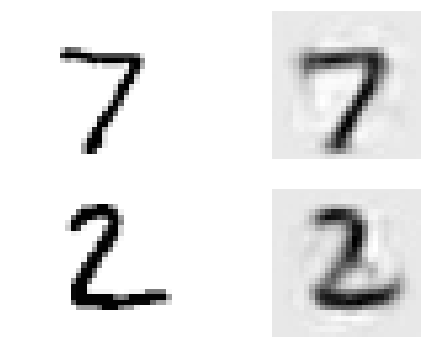

In [42]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# 희소 오토인코더

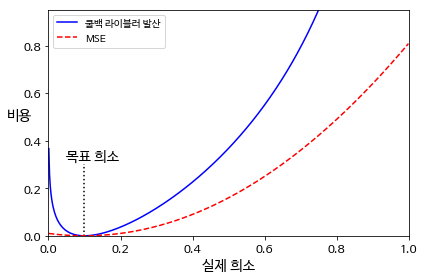

In [43]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "목표 희소", fontsize=14)
plt.plot(q, kl_div, "b-", label="쿨백 라이블러 발산")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("실제 희소")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [44]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # 희소 코딩 유닛
n_outputs = n_inputs

In [45]:
def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # 책에는 없음

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # 책에는 없음
outputs = tf.layers.dense(hidden1, n_outputs)                     # 책에는 없음

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [46]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [47]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 0.13819474 	희소 손실: 0.4184438 	전체 손실: 0.2218835
1 훈련 MSE: 0.059185907 	희소 손실: 0.010747713 	전체 손실: 0.06133545
2 훈련 MSE: 0.053931113 	희소 손실: 0.01995793 	전체 손실: 0.0579227
3 훈련 MSE: 0.04771372 	희소 손실: 0.039470345 	전체 손실: 0.05560779
4 훈련 MSE: 0.044841796 	희소 손실: 0.011593144 	전체 손실: 0.047160424
5 훈련 MSE: 0.04044193 	희소 손실: 0.092471 	전체 손실: 0.058936134
6 훈련 MSE: 0.03886659 	희소 손실: 0.04581263 	전체 손실: 0.048029117
7 훈련 MSE: 0.037868652 	희소 손실: 0.07498071 	전체 손실: 0.052864797
8 훈련 MSE: 0.033122517 	희소 손실: 0.020321768 	전체 손실: 0.037186872
9 훈련 MSE: 0.031449173 	희소 손실: 0.095670156 	전체 손실: 0.050583206
10 훈련 MSE: 0.027398113 	희소 손실: 0.06570565 	전체 손실: 0.040539242
11 훈련 MSE: 0.024734963 	희소 손실: 0.08889264 	전체 손실: 0.04251349
12 훈련 MSE: 0.023367295 	희소 손실: 0.05766213 	전체 손실: 0.03489972
13 훈련 MSE: 0.023007901 	희소 손실: 0.06193536 	전체 손실: 0.035394974
14 훈련 MSE: 0.02123353 	희소 손실: 0.025881292 	전체 손실: 0.02640979
15 훈련 MSE: 0.022064691 	희소 손실: 0.48820361 	전체 손실: 0.119705416
16 훈련 MSE: 0.01910253 	희소 손실:

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


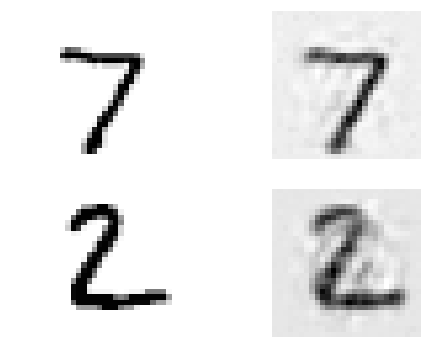

In [48]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

코딩층은 0에서 1사이의 값을 출력해야 하므로 시그모이드 활성화 함수를 사용합니다:

In [49]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

훈련 속도를 높이기 위해 입력을 0과 1사이로 정규화하고 비용 함수로 MSE 대신 크로스엔트로피를 사용합니다:

In [50]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

# 변이형 오토인코더

In [51]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [52]:
eps = 1e-10 # NaN을 반환하는 log(0)을 피하기 위한 안전항
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [53]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 훈련 전체 손실: 38016.934 	재구성 손실: 26717.334 	잠재 손실: 11299.599
1 훈련 전체 손실: 30065.5 	재구성 손실: 24319.137 	잠재 손실: 5746.3633
2 훈련 전체 손실: 32188.535 	재구성 손실: 24696.451 	잠재 손실: 7492.085
3 훈련 전체 손실: 29995.074 	재구성 손실: 24591.836 	잠재 손실: 5403.2393
4 훈련 전체 손실: 22977.074 	재구성 손실: 19545.846 	잠재 손실: 3431.228
5 훈련 전체 손실: 21461.336 	재구성 손실: 18221.758 	잠재 손실: 3239.5786
6 훈련 전체 손실: 17799.531 	재구성 손실: 14987.603 	잠재 손실: 2811.9297
7 훈련 전체 손실: 17872.271 	재구성 손실: 14900.03 	잠재 손실: 2972.2415
8 훈련 전체 손실: 16473.062 	재구성 손실: 13437.503 	잠재 손실: 3035.5598
9 훈련 전체 손실: 18285.943 	재구성 손실: 15230.208 	잠재 손실: 3055.7349
10 훈련 전체 손실: 17281.297 	재구성 손실: 14238.846 	잠재 손실: 3042.4512
11 훈련 전체 손실: 16178.416 	재구성 손실: 13091.535 	잠재 손실: 3086.881
12 훈련 전체 손실: 16544.488 	재구성 손실: 13217.236 	잠재 손실: 3327.253
13 훈련 전체 손실: 16427.021 	재구성 손실: 13077.631 	잠재 손실: 3349.391
14 훈련 전체 손실: 16616.738 	재구성 손실: 13293.669 	잠재 손실: 3323.07
15 훈련 전체 손실: 16271.476 	재구성 손실: 13142.443 	잠재 손실: 3129.0325
16 훈련 전체 손실: 16567.523 	재구성 손실: 13333.615 	잠재 손실: 3233.9075


In [55]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 숫자 이미지 생성

모델을 훈련시켜 랜덤한 이미지를 생성해 보겠습니다:

In [56]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 훈련 전체 손실: 17792.723 	재구성 손실: 14123.082 	잠재 손실: 3669.6401
1 훈련 전체 손실: 17332.346 	재구성 손실: 13560.099 	잠재 손실: 3772.2463
2 훈련 전체 손실: 16350.873 	재구성 손실: 12579.393 	잠재 손실: 3771.4807
3 훈련 전체 손실: 16581.45 	재구성 손실: 12810.662 	잠재 손실: 3770.7861
4 훈련 전체 손실: 16224.016 	재구성 손실: 12450.172 	잠재 손실: 3773.8433
5 훈련 전체 손실: 15628.262 	재구성 손실: 11819.755 	잠재 손실: 3808.5068
6 훈련 전체 손실: 16081.008 	재구성 손실: 12179.777 	잠재 손실: 3901.231
7 훈련 전체 손실: 15772.933 	재구성 손실: 12021.411 	잠재 손실: 3751.5212
8 훈련 전체 손실: 16276.584 	재구성 손실: 12404.785 	잠재 손실: 3871.7988
9 훈련 전체 손실: 15589.723 	재구성 손실: 11740.717 	잠재 손실: 3849.0063
10 훈련 전체 손실: 15931.363 	재구성 손실: 12031.385 	잠재 손실: 3899.9783
11 훈련 전체 손실: 16112.865 	재구성 손실: 12238.496 	잠재 손실: 3874.369
12 훈련 전체 손실: 16002.043 	재구성 손실: 12185.183 	잠재 손실: 3816.8608
13 훈련 전체 손실: 15357.919 	재구성 손실: 11667.58 	잠재 손실: 3690.3389
14 훈련 전체 손실: 16208.517 	재구성 손실: 12264.615 	잠재 손실: 3943.9011
15 훈련 전체 손실: 15970.236 	재구성 손실: 12158.714 	잠재 손실: 3811.522
16 훈련 전체 손실: 15551.721 	재구성 손실: 11783.23 	잠재 손실: 3768.4

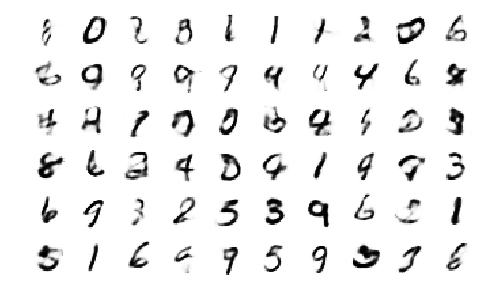

In [57]:
plt.figure(figsize=(8,50)) # 책에는 없음
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

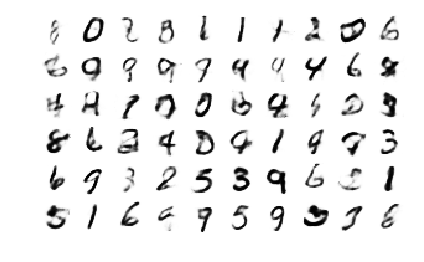

In [58]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

여기에서 잠재 변수 손실은 조금 다르게 계산된 점을 주목하세요:

In [59]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## 인코드 & 디코드

인코드:

In [60]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


디코드:

In [61]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


재구성 이미지를 그려봅니다:

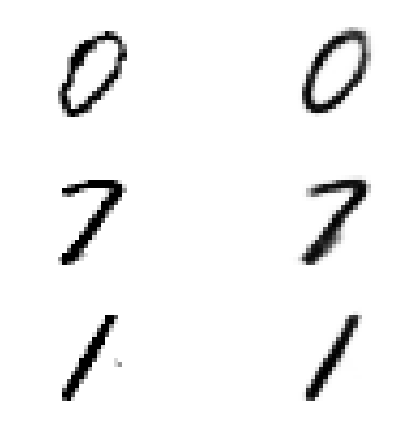

In [62]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## 숫자 이미지 보간

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


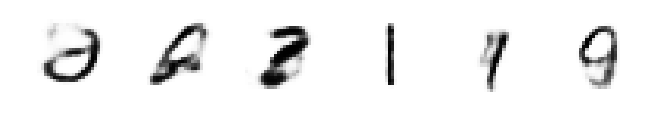

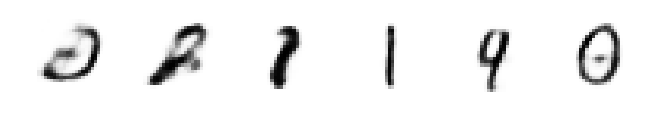

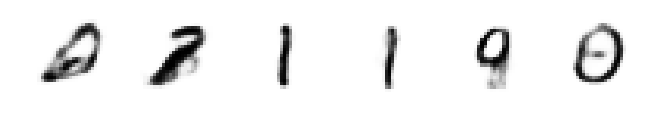

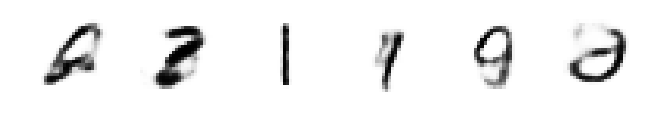

In [63]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# 연습문제 해답

Coming soon...